In [297]:
from sqlalchemy import create_engine
from matplotlib.backends.backend_pdf import PdfPages
#Step One: Import Modules

import time
import pyodbc as pyodbc
import datetime as datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle

import nltk as nl
import sklearn as sk
import matplotlib as mp
#import xgboost as xg
import seaborn as sb

#SKLEARN METHODS
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import rand_score
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import datetime as dt
import numpy as np
#import pyodbc
import sys
import os

mp.style.use('ggplot')


from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

In [240]:
def read_csv(fn='./specs/question_1.csv'):
    df=pd.read_csv(fn)
    return df

def plot_dataset(df,fn='./output/question_1_1.pdf',cluster_label='org_cluster',centroids=[]):
    
    if cluster_label=='org_cluster':
        forced_colour_map={0:'Red',1:'Blue',2:'Green'}
    else:
        forced_colour_map={1:'Green',2:'Red',0:'Blue'}
    
    plt.scatter(df['x'], df['y'], c= df[cluster_label].map(forced_colour_map), cmap='viridis')
    
    if len(centroids)>0:
        print('')
        plt.scatter(centroids['x'],centroids['y'],c=centroids['cluster_kmean_center'].map(forced_colour_map),cmap='viridis',marker='+')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('X vs Y with {}'.format(cluster_label))
    plt.savefig(fn)
    plt.show()
    plt.close()
    
    return


def plot_inertia(y_axis,x_axis=range(1,11),fn='./output/question_1_2.pdf'):
    plt.plot(x_axis, y_axis)
    plt.xlabel('No Of Clusters')
    plt.ylabel('Inertia')
    plt.title('Clusters vs Inertia')
    plt.savefig(fn)
    plt.show()
    plt.close()
    return

def generate_cluster_dict(df):
    
    cluster_dict=dict()
    count_value=[]
    
    for cluster_count in range(1,11):

        model=KMeans(n_clusters=cluster_count
                       , init='k-means++'
                       , n_init=10
                       , max_iter=300
                       , tol=0.0001
                       , verbose=0
                       , random_state=0
                       , copy_x=True
                       , algorithm='auto')

        predictions=model.fit_predict(df[['x','y']])

        model_inertia=model.inertia_

        count_value+=[model_inertia]

        rand_scoring=rand_score(df['org_cluster'], predictions)
        
        if cluster_count>1:
            sil_score=silhouette_score(df[['x','y']]
                                       , labels=predictions
                                       , metric='euclidean'
                                       , sample_size=None
                                       , random_state=0)
        else:
            sil_score=-1

        cluster_dict[cluster_count]={'Predictions':predictions
                                        ,'Model':model
                                        ,'Centroids':model.cluster_centers_
                                        ,'Labels': model.labels_
                                        ,'Value':model_inertia
                                        ,'Rand_Score':rand_scoring
                                        ,'Silhouette_Score':sil_score}
        
        
    return cluster_dict,count_value

def add_kmeans_pred_to_df(df,pred):
    df['cluster_kmeans']=pred
    return df

def question_one():
    
    df=read_csv()
    
    #Part 1
    plot_dataset(df=df
                 ,fn='./output/question_1_1.pdf'
                 ,cluster_label='org_cluster')
    
    cluster_dict,interia_values=generate_cluster_dict(df=df)
    
    #Part 2
    plot_inertia(x_axis=range(1,11),y_axis=interia_values,fn='./output/question_1_2.pdf')
    
    
    #Part 3
    print("""
-----
Question 1 Part 3:
----
Random Index: {} | Silhouette Score: {} | Index={}
-----
""".format(cluster_dict[3]['Rand_Score'],cluster_dict[3]['Silhouette_Score'],3))
    
    #Part 4
    df=add_kmeans_pred_to_df(df=df
                          ,pred=cluster_dict[3]['Predictions'])
    
    df.to_csv('./output/question_1.csv')
    
    centroid_df=pd.DataFrame(cluster_dict[3]['Centroids'],columns=['x','y']).reset_index()
    centroid_df.columns=['cluster_kmean_center','x','y']
    
    plot_dataset(df=df
                 ,fn='./output/question_1_5.pdf'
                 ,cluster_label='cluster_kmeans'
                ,centroids=centroid_df)
    
    return df,cluster_dict

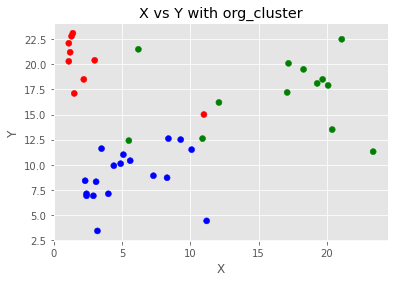

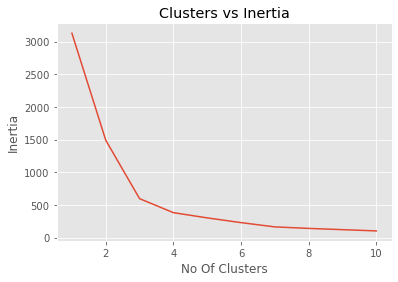


-----
Question 1 Part 3:
----
Random Index: 0.8666666666666667 | Silhouette Score: 0.6093075207861811 | Index=3
-----




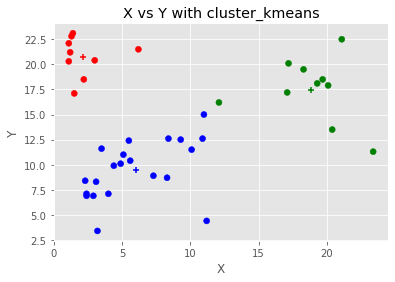

In [241]:
df,cluster_dict=question_one()

In [287]:
def remove_unimportant_columns(df,cols_to_remove=['NAME', 'MANUF', 'TYPE', 'RATING']):
    df_original_columns=set(df.columns)
    df_new_columns=df_original_columns - set(cols_to_remove)
    df=df[list(df_new_columns)]
    return df
   
def question_two_generate_cluster_dict(df):
    
    cluster_dict=dict()
    count_value=[]
    
    run_config=[[5,5,100],[5,100,100],[3,100,100]]
    
    for run_type in run_config:
        
        cluster_count=run_type[0]
        initialisations=run_type[1]
        max_iterations=run_type[2]

        model=KMeans(n_clusters=cluster_count
                       , init='k-means++'
                       , n_init=initialisations
                       , max_iter=max_iterations
                       , tol=0.0001
                       , verbose=0
                       , random_state=0
                       , copy_x=True
                       , algorithm='auto')

        predictions=model.fit_predict(df)

        model_inertia=model.inertia_

        count_value+=[model_inertia]
        
        if cluster_count>1:
            sil_score=silhouette_score(df
                                       , labels=predictions
                                       , metric='euclidean'
                                       , sample_size=None
                                       , random_state=0)
        else:
            sil_score=-1

        cluster_dict['{}_{}_{}'.format(cluster_count,initialisations,max_iterations)]={'Predictions':predictions
                                        ,'Model':model
                                        ,'Centroids':model.cluster_centers_
                                        ,'Labels': model.labels_
                                        ,'Value':model_inertia
                                        ,'Rand_Score':rand_scoring
                                        ,'Silhouette_Score':sil_score}
        
        
    return cluster_dict,count_value

In [291]:
def question_two():
    
    df=read_csv(fn='./specs/question_2.csv')
    
    df=remove_unimportant_columns(df,cols_to_remove=['NAME', 'MANUF', 'TYPE', 'RATING'])
    
    cluster_dict,count_values=question_two_generate_cluster_dict(df)
    
    equal_predictions=[]
    
    for k in range(len(cluster_dict['5_5_100']['Predictions'])):
        
        if cluster_dict['5_5_100']['Predictions'][k]==cluster_dict['5_100_100']['Predictions'][k]:
            equal_predictions+=[k]
            
    print("""
----

QUESTION TWO PART 4:

----""".format(len(equal_predictions)))
    print("""Number of equal predictions: {} """.format(len(equal_predictions)))
    print("""Number of not-equal predictions: {} """.format(len(cluster_dict['5_5_100']['Predictions']) - len(equal_predictions)))
    
    df['config1']=cluster_dict['5_5_100']['Predictions']
    df['config2']=cluster_dict['5_100_100']['Predictions']
    df['config3']=cluster_dict['3_100_100']['Predictions']
    
    print("""
----

QUESTION TWO PART 6:

----

config1: 5_5_100    : Silhouette: {}
config2: 5_100_100  : Silhouette: {}
config3: 3_10_100   : Silhouette: {}

    """.format(cluster_dict['5_5_100']['Silhouette_Score']
              ,cluster_dict['5_100_100']['Silhouette_Score']
              ,cluster_dict['3_100_100']['Silhouette_Score'])     
        
)
    
    
    print("""
----

QUESTION TWO PART 6:

----

config1: 5_5_100    : Silhouette: {}
config2: 5_100_100  : Silhouette: {}
config3: 3_10_100   : Silhouette: {}

    """.format(cluster_dict['5_5_100']['Value']
              ,cluster_dict['5_100_100']['Value']
              ,cluster_dict['3_100_100']['Value']))  
    
    #df.to_csv('./output/question_2.csv')
    
    return df,cluster_dict

In [292]:
q2_df,q2_cluster_dict=question_two()


----

QUESTION TWO PART 4:

----
Number of equal predictions: 6 
Number of not-equal predictions: 71 

----

QUESTION TWO PART 6:

----

config1: 5_5_100    : Silhouette: 0.33509164287562027
config2: 5_100_100  : Silhouette: 0.3601346535452705
config3: 3_10_100   : Silhouette: 0.46430924739274937

    

----

QUESTION TWO PART 6:

----

config1: 5_5_100    : Silhouette: 221721.30216033317
config2: 5_100_100  : Silhouette: 221177.56684887334
config3: 3_10_100   : Silhouette: 349679.2299669071

    


In [245]:

def question_three_generate_cluster_dict(df):
    
    cluster_dict=dict()
    count_value=[]
    
    model=KMeans(n_clusters=7
                   , init='k-means++'
                   , n_init=5
                   , max_iter=100
                   , tol=0.0001
                   , verbose=0
                   , random_state=0
                   , copy_x=True
                   , algorithm='auto')

    predictions=model.fit_predict(df[['x','y']])

    model_inertia=model.inertia_

    count_value+=[model_inertia]

    if cluster_count>1:
        sil_score=silhouette_score(df[['x','y']]
                                   , labels=predictions
                                   , metric='euclidean'
                                   , sample_size=None
                                   , random_state=0)
    else:
        sil_score=-1

    cluster_dict[7]={'Predictions':predictions
                                    ,'Model':model
                                    ,'Centroids':model.cluster_centers_
                                    ,'Labels': model.labels_
                                    ,'Value':model_inertia
                                    ,'Silhouette_Score':sil_score}
        
        
    return cluster_dict,count_value



In [246]:
def question_three_plot_dataset(df,fn='./output/question_3_1.pdf',cluster_label='k-means',centroids=[]):
    
    
    plt.scatter(df['x'], df['y'], c= df[cluster_label], cmap='viridis')
    
    if len(centroids)>0:
        plt.scatter(centroids['x'],centroids['y'],c=centroids.index,cmap='viridis',marker='+')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('X vs Y with {}'.format(cluster_label))
    plt.savefig(fn)
    plt.show()
    plt.close()
    
    return

In [261]:
def question_three_dbscan(df,scaler='Standard'):
    
    cluster_dict=dict()
    
    X=df[['x','y']].values
    
    if scaler=='Standard':
        scaler = StandardScaler()
    elif scaler=='MinMax':    
        scaler = MinMaxScaler()
    
    X = scaler.fit_transform(X)
    
    for epsilon in [0.04,0.08]:
    
        model=DBSCAN(eps=epsilon
                     , min_samples=4
                     , metric='euclidean'
                     , metric_params=None
                     , algorithm='auto'
                     , leaf_size=30
                     , p=None
                     , n_jobs=None)

        predictions=model.fit_predict(X)

        if len(set(model.labels_))>1:
            sil_score=silhouette_score(X
                                       , labels=predictions
                                       , metric='euclidean'
                                       , sample_size=None
                                       , random_state=0)
        else:
            sil_score=-1

        cluster_dict[epsilon]={'Predictions':predictions
                                        ,'Model':model
                                        ,'Labels': model.labels_
                                        ,'Silhouette_Score':sil_score}

    return cluster_dict

In [269]:


def question_three():
    df=read_csv(fn='./specs/question_3.csv')
    
    df=remove_unimportant_columns(df,cols_to_remove=['ID'])
    
    kmeans_cluster_dict, count_value = question_three_generate_cluster_dict(df)
    
    df['k-means']=kmeans_cluster_dict[7]['Predictions']
    
    question_three_plot_dataset(df,fn='./output/question_3_1.pdf',cluster_label='k-means',centroids=[])
    
    db_scan_cluster_result=question_three_dbscan(df,scaler='MinMax')
    
    df['dbscan1']=db_scan_cluster_result[0.04]['Predictions']
    df['dbscan2']=db_scan_cluster_result[0.08]['Predictions']
    
    question_three_plot_dataset(df,fn='./output/question_3_2.pdf',cluster_label='dbscan1',centroids=[])
    question_three_plot_dataset(df,fn='./output/question_3_3.pdf',cluster_label='dbscan2',centroids=[])
    
    df.to_csv('./output/question_3.csv')
    
    return df,kmeans_cluster_dict,db_scan_cluster_result

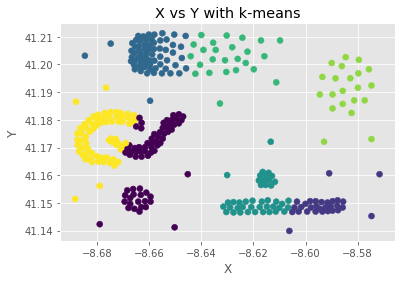

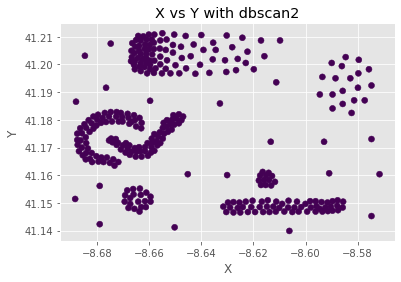

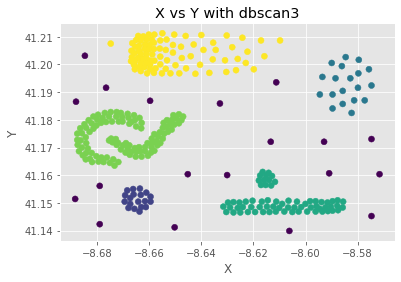

In [270]:
df,kmeans_cluster_dict,db_scan_cluster_result = question_three()

In [277]:
q2_df[['config1','config2']].count()

config1    77
config2    77
dtype: int64

In [281]:
q2_df[['config1','config2']].groupby('config1').agg(['count', 'size', 'nunique']).stack()

config2
config1                 
0       count         19
        size          19
        nunique        3
1       count         14
        size          14
        nunique        2
2       count          9
        size           9
        nunique        1
3       count         19
        size          19
        nunique        1
4       count         16
        size          16
        nunique        2

In [280]:
q2_df[['config1','config2']].groupby('config2').agg(['count', 'size', 'nunique']).stack()

config1
config2                 
0       count         26
        size          26
        nunique        3
1       count          9
        size           9
        nunique        1
2       count         11
        size          11
        nunique        1
3       count         22
        size          22
        nunique        2
4       count          9
        size           9
        nunique        2

In [293]:
q2_df

,FAT,PROTEIN,POTASS,CUPS,SHELF,SODIUM,CALORIES,FIBER,SUGARS,CARBO,WEIGHT,VITAMINS,config1,config2,config3
0,1,4,280,0.33,3,130,70,10.0,6,5.0,1.0,25,2,1,0
1,5,3,135,1.00,3,15,120,2.0,8,8.0,1.0,0,1,2,1
2,1,4,320,0.33,3,260,70,9.0,5,7.0,1.0,25,2,1,0
3,0,4,330,0.50,3,140,50,14.0,0,8.0,1.0,25,2,1,0
4,2,2,-1,0.75,3,200,110,1.0,8,14.0,1.0,25,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1,2,60,0.75,3,250,110,0.0,3,21.0,1.0,25,4,3,2
73,1,1,25,1.00,2,140,110,0.0,12,13.0,1.0,25,0,4,2
74,1,3,115,0.67,1,230,100,3.0,3,17.0,1.0,25,4,0,2
75,1,3,110,1.00,1,200,100,3.0,3,17.0,1.0,25,3,0,2


In [286]:
display(q2_cluster_dict['5_5_100']['Value'])
display(q2_cluster_dict['5_100_100']['Value'])
display(q2_cluster_dict['3_10_100']['Value'])

221721.30216033317

221177.56684887334

349679.2299669071

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt Qx
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1711220787  incidence  Qtriangulate  Qxact-merge  _zero-centrum
  _max-width  5  Error-roundoff 7.3e-14  _one-merge 8e-13  _near-inside 4e-12
  Visible-distance 4.4e-13  U-max-coplanar 4.4e-13  Width-outside 8.8e-13
  _wide-facet 2.6e-12  _maxoutside 8.8e-13

precision problems (corrected unless 'Q0' or an error)
      6 nearly singular or axis-parallel hyperplanes
      6 zero divisors during back substitute
    413 zero divisors during gaussian elimination

The input to qhull appears to be less than 5 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p177(v6):     2     0  -8.7    41     4
- p205(v5):     1     0  -8.6    41    -1
- p199(v4):     1     0  -8.6    41    -1
- p196(v3):     2     0  -8.7    41    -1
- p19(v2):     3     0  -8.6    41     2
- p0(v1):     0     0  -8.7    41     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 7.3e-14.  The center point, facets and distances
to the center point are as follows:

center point      1.5        0   -8.636    41.17      0.5

facet p205 p199 p196 p19 p0 distance=    0
facet p177 p199 p196 p19 p0 distance=    0
facet p177 p205 p196 p19 p0 distance=    0
facet p177 p205 p199 p19 p0 distance=    0
facet p177 p205 p199 p196 p0 distance=    0
facet p177 p205 p199 p196 p19 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:         0         3  difference=    3
  1:         0         0  difference=    0
  2:    -8.685  -2.225e-308  difference= 8.685
  3:     41.14     41.21  difference= 0.07137
  4:        -1         4  difference=    5

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 7.3e-14.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


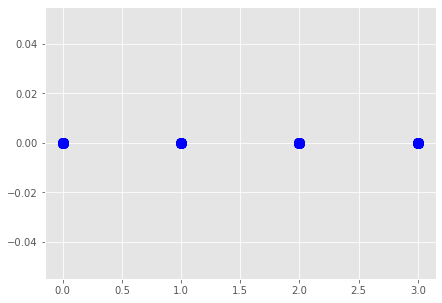

In [300]:

def drawclusters(ax,ncluster=5):
    for i in range(ncluster):
        points = X[y == i]
        ax.scatter(points[:, 0], points[:, 1], s=100, c=col[i], label=f'Cluster {i + 1}')
        hull = ConvexHull(points)
        vert = np.append(hull.vertices, hull.vertices[0])  # close the polygon by appending the first point at the end
        ax.plot(points[vert, 0], points[vert, 1], '--', c=col[i])
        ax.fill(points[vert, 0], points[vert, 1], c=col[i], alpha=0.2)
    ax.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', label='Centroids', marker='x')

x_df = read_csv('./specs/question_2.csv')
x_df=remove_unimportant_columns(df,cols_to_remove=['NAME', 'MANUF', 'TYPE', 'RATING'])
X=x_df.values
col = ['blue', 'green','red','yellow','orange']
cluster_count = 5
initialisations=100
max_iterations=100
kmeans = KMeans(n_clusters=cluster_count
                       , init='k-means++'
                       , n_init=initialisations
                       , max_iter=max_iterations
                       , tol=0.0001
                       , verbose=0
                       , random_state=0
                       , copy_x=True
                       , algorithm='auto').fit(X)
y = kmeans.labels_
centroids = kmeans.cluster_centers_
fig, ax = plt.subplots(1, figsize=(7, 5))
drawclusters(ax,cluster_count)
ax.legend()
plt.tight_layout()
plt.show()